https://www.kaggle.com/code/sugghi/training-3rd-place-solution/notebook
ここのソリューションをBybitで実装してみる。

変更点：
    ・　通貨ペアーは取引の多いものを選ぶ（１４まで選ぶと１分足が作れない可能性があるため減らす）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime

import pickle
import gc

from tqdm import tqdm

In [2]:
n_fold = 7
seed0 = 8586

In [3]:
# そのままコピー
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
import rbot

bb_btcusd = rbot.DummyBb()
bb_btcusd.market_type = "BTCUSD"
bb_btcusdt = rbot.DummyBb()
bb_btcusdt.market_type = "BTCUSDT"

bb_ethusd = rbot.DummyBb()
bb_ethusd.market_type = "ETHUSD"
bb_ethusdt = rbot.DummyBb()
bb_ethusdt.market_type = "ETHUSDT"

bb_xrpusdt = rbot.DummyBb()
bb_xrpusdt.market_type = "XRPUSDT"
bb_xrpusd = rbot.DummyBb()
bb_xrpusd.market_type = "XRPUSD"

bb_solusdt = rbot.DummyBb()
bb_solusdt.market_type = "SOLUSDT"


In [5]:
# 注意　１０GB レベルでDiskを消費します。
# 2回目は LOAD_NEWをFalseにするとダンプファイルからロードするので高速です。
LOAD_NEW = False
LOAD_DAYS = 100

if LOAD_NEW:
    bb_btcusd.log_load(LOAD_DAYS)
    bb_btcusd.dump()
    bb_btcusdt.log_load(LOAD_DAYS)
    bb_btcusdt.dump()
    bb_ethusd.log_load(LOAD_DAYS)
    bb_ethusd.dump()
    bb_ethusdt.log_load(LOAD_DAYS)
    bb_ethusdt.dump()
    bb_xrpusd.log_load(LOAD_DAYS)
    bb_xrpusd.dump()
    bb_xrpusdt.log_load(LOAD_DAYS)
    bb_xrpusdt.dump()
    bb_solusdt.log_load(LOAD_DAYS)
    bb_solusdt.dump()
else:
    bb_btcusd.restore()
    bb_btcusdt.restore()
    bb_ethusd.restore()
    bb_ethusdt.restore()
    bb_xrpusd.restore()
    bb_xrpusdt.restore()
    bb_solusdt.restore()


In [6]:
OFFSET_PERIOD = 5
#OFFSET_PERIOD = 15

# diff の方向はマイナスが正しい。
def log_return(series, periods=OFFSET_PERIOD):
    return np.log(series).diff(periods= - periods)

# Closeのログリターンを計算する（Closeでいいのかな？）
def make_df(dummy_bb, asset_id):
    df = rbot.array_to_df(dummy_bb.ohlcv(0, 0, 60))
    df['Target'] = log_return((df['close']+df['open']+df['high']+df['low'])/4, OFFSET_PERIOD)
    df['Asset_ID'] = asset_id
    
    return df

In [7]:
df_btcusd = make_df(bb_btcusd, 0)
df_btcusdt = make_df(bb_btcusdt, 1)
df_ethusd = make_df(bb_ethusd, 2)
df_ethusdt = make_df(bb_ethusdt, 3)
df_xrpusd = make_df(bb_xrpusd, 4)
df_xrpusdt = make_df(bb_xrpusdt, 5)
df_solusdt = make_df(bb_solusdt, 6)

df_train = pd.concat([df_btcusd, df_btcusdt, df_ethusd, df_ethusdt, df_xrpusd, df_xrpusdt, df_solusdt])
df_train = reduce_mem_usage(df_train)
df_train

Memory usage of dataframe is 61.43 MB
Memory usage after optimization is: 22.08 MB
Decreased by 64.1%


,open,high,low,close,volume,Target,Asset_ID
timestamp,,,,,,,
2022-03-27 00:00:00+00:00,44544.00000,44544.00000,44544.00000,44544.00000,122635.000000,-0.000132,0
2022-03-27 00:01:00+00:00,44544.00000,44544.00000,44512.00000,44512.00000,129101.000000,-0.000098,0
2022-03-27 00:02:00+00:00,44512.00000,44512.00000,44480.00000,44512.00000,407347.000000,-0.000421,0
2022-03-27 00:03:00+00:00,44512.00000,44512.00000,44512.00000,44512.00000,204417.000000,-0.000194,0
2022-03-27 00:04:00+00:00,44512.00000,44544.00000,44512.00000,44544.00000,487144.000000,0.000048,0
...,...,...,...,...,...,...,...
2022-07-04 23:55:00+00:00,36.84375,36.84375,36.78125,36.78125,1898.699951,NaN,6
2022-07-04 23:56:00+00:00,36.78125,36.81250,36.78125,36.81250,2975.899902,NaN,6
2022-07-04 23:57:00+00:00,36.81250,36.84375,36.78125,36.81250,3651.199951,NaN,6


In [8]:
df_train['timestamp'] = df_train.index.astype('int64')
#df_train['Close'] = df_train["close"] 
df_train['Close'] = (df_train["open"] + df_train["close"] + df_train["high"] + df_train["low"])/4
df_train = df_train.reset_index(drop=True)
df_train = reduce_mem_usage(df_train)
df_train


Memory usage of dataframe is 24.00 MB
Memory usage after optimization is: 29.76 MB
Decreased by -24.0%


,open,high,low,close,volume,Target,Asset_ID,timestamp,Close
0,44544.00000,44544.00000,44544.00000,44544.00000,122635.000000,-0.000132,0,1648339200000000000,inf
1,44544.00000,44544.00000,44512.00000,44512.00000,129101.000000,-0.000098,0,1648339260000000000,inf
2,44512.00000,44512.00000,44480.00000,44512.00000,407347.000000,-0.000421,0,1648339320000000000,inf
3,44512.00000,44512.00000,44512.00000,44512.00000,204417.000000,-0.000194,0,1648339380000000000,inf
4,44512.00000,44544.00000,44512.00000,44544.00000,487144.000000,0.000048,0,1648339440000000000,inf
...,...,...,...,...,...,...,...,...,...
1006489,36.84375,36.84375,36.78125,36.78125,1898.699951,NaN,6,1656978900000000000,36.8125
1006490,36.78125,36.81250,36.78125,36.81250,2975.899902,NaN,6,1656978960000000000,36.8125
1006491,36.81250,36.84375,36.78125,36.81250,3651.199951,NaN,6,1656979020000000000,36.8125
1006492,36.81250,36.81250,36.65625,36.65625,3171.600098,NaN,6,1656979080000000000,36.7500


In [9]:
NUM_OF_ASSETS = 7

train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm( range(NUM_OF_ASSETS) ):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
        
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
train_merged = train_merged.sort_values('timestamp', ascending=True)
display(train_merged.head())


100%|██████████| 7/7 [00:00<00:00, 37.71it/s]


,timestamp,Close_0,Target_0,Close_1,Target_1,Close_2,Target_2,Close_3,Target_3,Close_4,Target_4,Close_5,Target_5,Close_6,Target_6
0,1648339200000000000,inf,-0.000132,inf,-0.000444,3146.0,0.000608,3144.0,0.000406,0.832520,0.001051,0.833008,0.000841,101.750,0.001106
1,1648339260000000000,inf,-0.000098,inf,-0.000332,3146.0,0.000878,3144.0,0.000704,0.832520,0.001112,0.833008,0.001171,101.625,0.001353
2,1648339320000000000,inf,-0.000421,inf,-0.000627,3144.0,0.000819,3144.0,0.000756,0.832520,0.000932,0.832520,0.000901,101.625,0.001316
3,1648339380000000000,inf,-0.000194,inf,-0.000377,3144.0,0.000923,3142.0,0.000951,0.832031,0.000541,0.832031,0.000391,101.750,0.002018
4,1648339440000000000,inf,0.000048,inf,-0.000037,3144.0,0.000680,3142.0,0.000955,0.832031,0.000210,0.832031,0.000421,101.750,0.001993


In [10]:
for id in range(NUM_OF_ASSETS):
    # print(id, train_merged[f'Close_{id}'].isnull().sum())   # Number of missing before forward fill
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('object').fillna(method='ffill', limit=100)
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('float64')


In [11]:
#lags = [60,300,900]
lags = [15,30, 60, 120, 240, 480]

def get_features(df, train=True):   
    if train == True:
        totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))
        valid_window = [totimestamp("12/03/2021")]
#         valid_window = [totimestamp("15/08/2021")]  #検証用
        df['train_flg'] = np.where(df['timestamp']>=valid_window[0], 0,1)

        supple_start_window = [totimestamp("22/09/2021")]

        #if use_supple_for_train:
        #    df['train_flg'] = np.where(df['timestamp']>=supple_start_window[0], 1 ,df['train_flg']  )
   
    for id in range(NUM_OF_ASSETS):    
        for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(NUM_OF_ASSETS):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    if train == True:
        for id in range(NUM_OF_ASSETS):
            df = df.drop([f'Close_{id}'], axis=1)
        oldest_use_window = [totimestamp("12/01/2019")]
        df = df[  df['timestamp'] >= oldest_use_window[0]   ]

    return df

In [12]:
feat = get_features(train_merged)
feat

/var/folders/5r/xmxmz7gj2cjcb7d65tgwvrt40000gn/T/ipykernel_47237/2827225628.py:18: RuntimeWarning: invalid value encountered in true_divide
  df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
/var/folders/5r/xmxmz7gj2cjcb7d65tgwvrt40000gn/T/ipykernel_47237/2827225628.py:19: RuntimeWarning: invalid value encountered in true_divide
  df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
/var/folders/5r/xmxmz7gj2cjcb7d65tgwvrt40000gn/T/ipykernel_47237/2827225628.py:24: RuntimeWarning: invalid value encountered in subtract
  df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )


,timestamp,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,train_flg,log_close/mean_15_id0,...,log_close/mean_480-mean_close/mean_480_id2,log_return_480-mean_log_returns_480_id2,log_close/mean_480-mean_close/mean_480_id3,log_return_480-mean_log_returns_480_id3,log_close/mean_480-mean_close/mean_480_id4,log_return_480-mean_log_returns_480_id4,log_close/mean_480-mean_close/mean_480_id5,log_return_480-mean_log_returns_480_id5,log_close/mean_480-mean_close/mean_480_id6,log_return_480-mean_log_returns_480_id6
0,1648339200000000000,-0.000132,-0.000444,0.000608,0.000406,0.001051,0.000841,0.001106,0,inf,...,-inf,0.029578,-inf,0.027142,-inf,-0.066139,-inf,-0.066308,-inf,0.075727
1,1648339260000000000,-0.000098,-0.000332,0.000878,0.000704,0.001112,0.001171,0.001353,0,inf,...,-inf,0.029130,-inf,0.028495,-inf,-0.066586,-inf,-0.066000,-inf,0.074962
2,1648339320000000000,-0.000421,-0.000627,0.000819,0.000756,0.000932,0.000901,0.001316,0,inf,...,-inf,0.030333,-inf,0.028529,-inf,-0.066552,-inf,-0.067307,-inf,0.074996
3,1648339380000000000,-0.000194,-0.000377,0.000923,0.000951,0.000541,0.000391,0.002018,0,inf,...,-inf,0.030266,-inf,0.027826,-inf,-0.067205,-inf,-0.067960,-inf,0.077072
4,1648339440000000000,0.000048,-0.000037,0.000680,0.000955,0.000210,0.000421,0.001993,0,inf,...,-inf,0.031168,-inf,0.028725,-inf,-0.068110,-inf,-0.068865,-inf,0.077081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143993,1656978900000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,-0.000078,0.000539,-0.000482,-0.000393,-0.010957,-0.018484,-0.009824,-0.016256,0.021341,0.034595
143994,1656978960000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,-0.000328,0.000138,0.000138,0.000075,-0.011044,-0.018003,-0.010653,-0.017273,0.021886,0.035063
143995,1656979020000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,-0.000625,-0.000008,-0.000159,-0.000071,-0.010559,-0.018162,-0.010172,-0.016676,0.021516,0.034917
143996,1656979080000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,-0.000187,-0.000291,-0.000589,-0.000321,-0.009959,-0.017418,-0.010316,-0.016675,0.021050,0.034706


In [13]:
# define features for LGBM
not_use_features_train = ['timestamp', 'train_flg']
for id in range(NUM_OF_ASSETS):
    not_use_features_train.append(f'Target_{id}')

features = feat.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

180

In [14]:
#del train_merged
#del df_train
gc.collect()

144

In [15]:
# define the evaluation metric
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [16]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [17]:
# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [18]:
def get_Xy_and_model_for_asset(df_proc, asset_id):
    df_proc = df_proc.loc[  (df_proc[f'Target_{asset_id}'] == df_proc[f'Target_{asset_id}'])  ]
    #if not_use_overlap_to_train:
    #   df_proc = df_proc.loc[  (df_proc['train_flg'] == 1)  ]
    
# EmbargoCV
    train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)
    print("entering time series cross validation loop")
    importances = []
    oof_pred = []
    oof_valid = []
    
    for split, train_test_split in enumerate(train_test_zip):
        gc.collect()
        
        print(f"doing split {split+1} out of {n_fold}")
        train_split, test_split = train_test_split
        train_split_index = df_proc['timestamp'].isin(train_split)
        test_split_index = df_proc['timestamp'].isin(test_split)
    
        train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                    df_proc.loc[train_split_index, f'Target_{asset_id}'].values, 
                                    feature_name = features, 
                                   )
        val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                                  df_proc.loc[test_split_index, f'Target_{asset_id}'].values, 
                                  feature_name = features, 
                                 )

        print(f"number of train data: {len(df_proc.loc[train_split_index])}")
        print(f"number of val data:   {len(df_proc.loc[test_split_index])}")

        model = lgb.train(params = params,
                          train_set = train_dataset, 
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['tr', 'vl'],
                          num_boost_round = 5000,
                          verbose_eval = 100,     
                          feval = correlation,
                         )
        importances.append(model.feature_importance(importance_type='gain'))
        
        file = f'trained_model_id{asset_id}_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_id{asset_id}_fold{split}.pkl'")
        print("")
            
        oof_pred += list(  model.predict(df_proc.loc[test_split_index, features])        )
        oof_valid += list(   df_proc.loc[test_split_index, f'Target_{asset_id}'].values    )
    
    
    plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))

    return oof_pred, oof_valid

In [19]:
# Weigthの計算が不明

df_asset_details = pd.DataFrame(data={
    'Asset_ID': [0, 1, 2, 3, 4, 5, 6], 
    'Weight': [1, 1, 1, 1, 1, 1, 1],
    "Asset_Name": ['BTCUSD', 'BTCUSDT', 'ETHUSD', 'ETHUSDT', 'XRPUSD', 'XRPUSDT', "SOLUSDT"],
    })
df_asset_details

,Asset_ID,Weight,Asset_Name
0,0,1,BTCUSD
1,1,1,BTCUSDT
2,2,1,ETHUSD
3,3,1,ETHUSDT
4,4,1,XRPUSD
5,5,1,XRPUSDT
6,6,1,SOLUSDT


In [20]:
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
    }

Training model for BTCUSD           (ID=0 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123423
number of val data:   20570


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00243307	tr's corr: 0.091551	vl's rmse: 0.00145476	vl's corr: 0.0356422
Early stopping, best iteration is:
[56]	tr's rmse: 0.00243496	tr's corr: 0.0753198	vl's rmse: 0.00145454	vl's corr: 0.0402663
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold0.pkl'

doing split 2 out of 7
number of train data: 123423
number of val data:   20570
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	tr's rmse: 0.00244056	tr's corr: 0.0604406	vl's rmse: 0.0014218	vl's corr: 0.0179016
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold1.pkl'

doing split 3 out of 7
number of train data: 123423
number of val data:   20570
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	tr's rmse: 0.00241038	tr's corr: 0.0563559	vl's rmse: 0.00170779	vl's corr: 0.00376206
Evaluated only: rmse
Trained mo

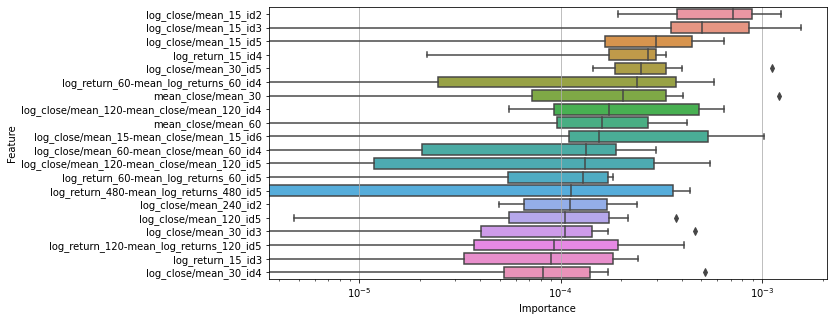

OOF corr score of BTCUSD (ID=0) is 0.03164. (Weight: 1.00000)


Training model for BTCUSDT          (ID=1 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123391
number of val data:   20565


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	tr's rmse: 0.00243182	tr's corr: 0.059717	vl's rmse: 0.00147172	vl's corr: 0.0238652
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold0.pkl'

doing split 2 out of 7
number of train data: 123391
number of val data:   20565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	tr's rmse: 0.00243657	tr's corr: 0.0558533	vl's rmse: 0.00143255	vl's corr: 0.00893653
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold1.pkl'

doing split 3 out of 7
number of train data: 123391
number of val data:   20565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00240686	tr's corr: 0.0338415	vl's rmse: 0.00171733	vl's corr: -0.00675814
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold2.pkl'

doing split 4 out of 7
number of train da

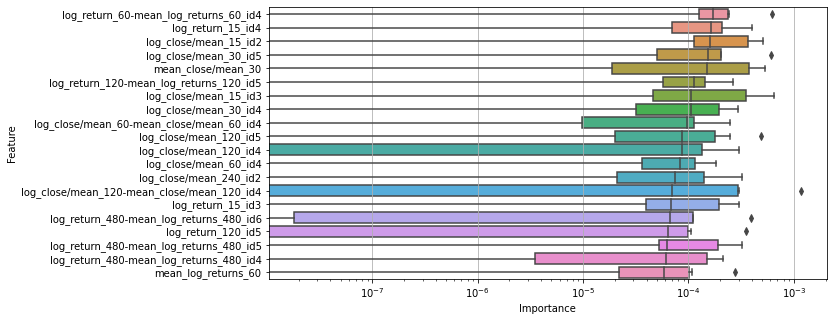

OOF corr score of BTCUSDT (ID=1) is 0.01741. (Weight: 1.00000)


Training model for ETHUSD           (ID=2 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123274
number of val data:   20545


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	tr's rmse: 0.00317844	tr's corr: 0.0831898	vl's rmse: 0.00175972	vl's corr: 0.0308718
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold0.pkl'

doing split 2 out of 7
number of train data: 123274
number of val data:   20545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00319902	tr's corr: 0.0594174	vl's rmse: 0.0015751	vl's corr: 0.00418608
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold1.pkl'

doing split 3 out of 7
number of train data: 123274
number of val data:   20545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	tr's rmse: 0.0031661	tr's corr: 0.0722989	vl's rmse: 0.00192854	vl's corr: 0.028428
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold2.pkl'

doing split 4 out of 7
number of train data: 1

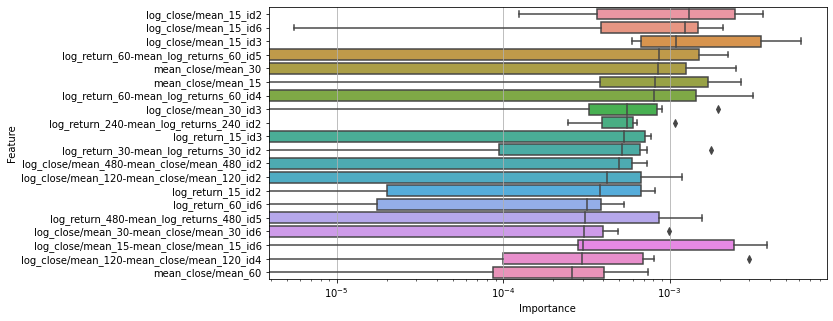

OOF corr score of ETHUSD (ID=2) is 0.04168. (Weight: 1.00000)


Training model for ETHUSDT          (ID=3 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123387
number of val data:   20564


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	tr's rmse: 0.00316557	tr's corr: 0.0843617	vl's rmse: 0.00176009	vl's corr: 0.0203872
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold0.pkl'

doing split 2 out of 7
number of train data: 123387
number of val data:   20564
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	tr's rmse: 0.00318464	tr's corr: 0.0665604	vl's rmse: 0.00158457	vl's corr: 0.00996658
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold1.pkl'

doing split 3 out of 7
number of train data: 123387
number of val data:   20564
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00315214	tr's corr: 0.047175	vl's rmse: 0.00194375	vl's corr: 0.00824524
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold2.pkl'

doing split 4 out of 7
number of train data

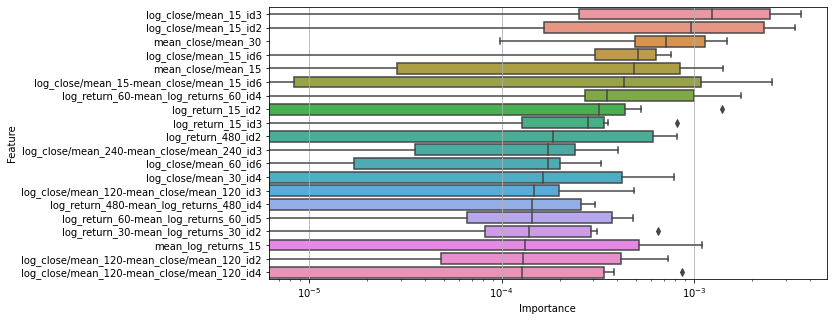

OOF corr score of ETHUSDT (ID=3) is 0.02998. (Weight: 1.00000)


Training model for XRPUSD           (ID=4 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 122998
number of val data:   20499


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00311941	tr's corr: 0.252056	vl's rmse: 0.00202007	vl's corr: 0.0762167
[200]	tr's rmse: 0.00309922	tr's corr: 0.276886	vl's rmse: 0.00201889	vl's corr: 0.0786099
Early stopping, best iteration is:
[203]	tr's rmse: 0.00309857	tr's corr: 0.278007	vl's rmse: 0.00201888	vl's corr: 0.07866
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold0.pkl'

doing split 2 out of 7
number of train data: 122998
number of val data:   20499
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00313292	tr's corr: 0.244734	vl's rmse: 0.00189305	vl's corr: 0.0210537
Early stopping, best iteration is:
[144]	tr's rmse: 0.00312202	tr's corr: 0.262356	vl's rmse: 0.00189286	vl's corr: 0.0259155
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold1.pkl'

doing split 3 out of 7
number of train data: 122998
number of val data:   20499
Training until validation scores don'

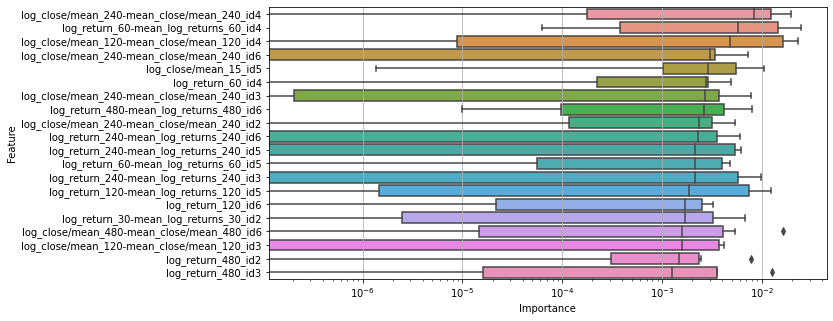

OOF corr score of XRPUSD (ID=4) is 0.06605. (Weight: 1.00000)


Training model for XRPUSDT          (ID=5 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 122850
number of val data:   20474


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00310615	tr's corr: 0.236641	vl's rmse: 0.00204914	vl's corr: 0.0737362
[200]	tr's rmse: 0.00308644	tr's corr: 0.264294	vl's rmse: 0.00204872	vl's corr: 0.0695127
Early stopping, best iteration is:
[152]	tr's rmse: 0.00309684	tr's corr: 0.249681	vl's rmse: 0.00204835	vl's corr: 0.0770689
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold0.pkl'

doing split 2 out of 7
number of train data: 122850
number of val data:   20474
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00312038	tr's corr: 0.233416	vl's rmse: 0.00190617	vl's corr: 0.0359992
Early stopping, best iteration is:
[94]	tr's rmse: 0.00312195	tr's corr: 0.233382	vl's rmse: 0.00190609	vl's corr: 0.0373782
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold1.pkl'

doing split 3 out of 7
number of train data: 122850
number of val data:   20474
Training until validation scores don

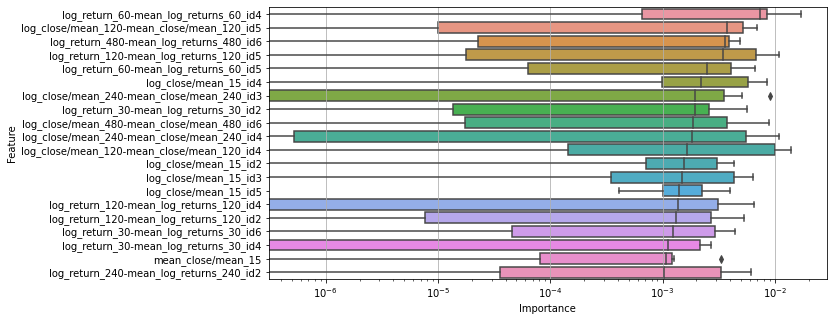

OOF corr score of XRPUSDT (ID=5) is 0.06340. (Weight: 1.00000)


Training model for SOLUSDT          (ID=6 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123360
number of val data:   20559


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	tr's rmse: 0.00467991	tr's corr: 0.158928	vl's rmse: 0.00338131	vl's corr: 0.0299714
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold0.pkl'

doing split 2 out of 7
number of train data: 123360
number of val data:   20559
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	tr's rmse: 0.00476539	tr's corr: 0.163817	vl's rmse: 0.00250662	vl's corr: 0.0211518
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold1.pkl'

doing split 3 out of 7
number of train data: 123360
number of val data:   20559
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00471762	tr's corr: 0.214407	vl's rmse: 0.00274669	vl's corr: 0.0566752
Early stopping, best iteration is:
[136]	tr's rmse: 0.00470643	tr's corr: 0.228696	vl's rmse: 0.00274467	vl's corr: 0.0683164
Evaluated only: rmse
Trained mod

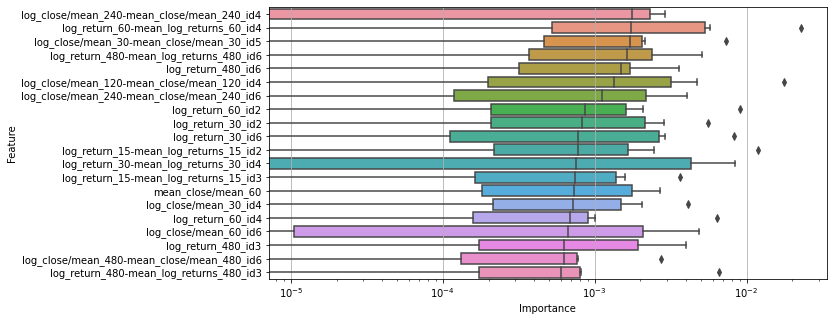

OOF corr score of SOLUSDT (ID=6) is 0.01983. (Weight: 1.00000)




In [21]:
oof = [ [] for id in range(NUM_OF_ASSETS)   ]

all_oof_pred = []
all_oof_valid = []
all_oof_weight = []

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    
    oof_pred, oof_valid = get_Xy_and_model_for_asset(feat, asset_id)
    
    weight_temp = float( df_asset_details.loc[  df_asset_details['Asset_ID'] == asset_id  , 'Weight'   ]  )
    
    all_oof_pred += oof_pred
    all_oof_valid += oof_valid
    all_oof_weight += [weight_temp] * len(oof_pred)
    
    oof[asset_id] = corr_score(     np.array(oof_pred)   ,    np.array(oof_valid)    )
    
    print(f'OOF corr score of {asset_name} (ID={asset_id}) is {oof[asset_id]:.5f}. (Weight: {float(weight_temp):.5f})')
    print('')
    print('')

In [22]:
woof = 0
for id in range(NUM_OF_ASSETS):
    woof += oof[id] * float(  df_asset_details.loc[  df_asset_details['Asset_ID'] == id  , 'Weight'   ] )
woof = woof / df_asset_details['Weight'].sum()

print(f'OOF corr scores are;')
for oof_score in oof:
    print(f'      {oof_score:.5f}')
print(f'  simple average corr score: {np.mean(oof):.5f}.')
print(f'weighted average corr score: {woof:.5f}.')
print(f'')

all_oof_wcorr = wcorr_score(     np.array(all_oof_pred),    np.array(all_oof_valid),  np.array(all_oof_weight)   )
print(f'        weighted corr score: {all_oof_wcorr:.5f}.')

OOF corr scores are;
      0.03164
      0.01741
      0.04168
      0.02998
      0.06605
      0.06340
      0.01983
  simple average corr score: 0.03857.
weighted average corr score: 0.03857.

        weighted corr score: 0.04047.
